In [61]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import geopandas as gpd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Read geographic data:

In [105]:
geo_data = pd.read_csv('bezirksgrenzen.csv')
geo_data

,gml_id,Gemeinde_name,Gemeinde_schluessel,Land_name,Land_schluessel,Schluessel_gesamt
0,s_wfs_alkis_bezirk.F176__1,Reinickendorf,12,Berlin,11,11000012
1,s_wfs_alkis_bezirk.F176__2,Charlottenburg-Wilmersdorf,4,Berlin,11,11000004
2,s_wfs_alkis_bezirk.F176__3,Treptow-Köpenick,9,Berlin,11,11000009
3,s_wfs_alkis_bezirk.F176__4,Pankow,3,Berlin,11,11000003
4,s_wfs_alkis_bezirk.F176__5,Neukölln,8,Berlin,11,11000008
5,s_wfs_alkis_bezirk.F176__6,Lichtenberg,11,Berlin,11,11000011
6,s_wfs_alkis_bezirk.F176__7,Marzahn-Hellersdorf,10,Berlin,11,11000010
7,s_wfs_alkis_bezirk.F176__8,Spandau,5,Berlin,11,11000005
8,s_wfs_alkis_bezirk.F176__9,Steglitz-Zehlendorf,6,Berlin,11,11000006
9,s_wfs_alkis_bezirk.F176__10,Mitte,1,Berlin,11,11000001


### Read population and employement data:

In [147]:
pop_data = pd.read_excel('bezirke_pop_einkommen.xlsx')
pop_data

,Borough,population,unemployed,income,pop_dens,lat,long
0,Mitte,329372,78525,3224,9773,52.533216,13.359796
1,Friedrichshain-Kreuzberg,255551,47173,3375,14373,52.515306,13.461612
2,Pankow,342152,32405,3358,3958,52.597637,13.436374
3,Charlottenburg-Wilmersdorf,260040,31792,3573,5289,52.507856,13.263952
4,Spandau,188909,46611,2761,2655,52.534769,13.195629
5,Steglitz-Zehlendorf,228052,19531,3553,3012,52.429591,13.242024
6,Tempelhof-Schöneberg,275919,47451,3194,6625,52.440442,13.388289
7,Neukölln,271521,71203,2855,7338,52.445432,13.443460
8,Treptow-Köpenick,205326,26189,3041,1610,52.417988,13.626403
9,Marzahn-Hellersdorf,214913,43276,2647,4350,52.522464,13.585384


## Use geopy library to get the latitude and longitude values of Berlin.

In [106]:
address = 'Berlin'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


Define Foursquare Credentials and Version

In [108]:
CLIENT_ID = 'MCP03JS2FUZASUQWARMTNPQMCY2BJYZ3YHSZLOXZHG2EU3O0' # your Foursquare ID
CLIENT_SECRET = 'WPMUKATGL5OJ3QL2LKVONZPFQZN3RQLZCQTRIFGLRMAWMLHO' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MCP03JS2FUZASUQWARMTNPQMCY2BJYZ3YHSZLOXZHG2EU3O0
CLIENT_SECRET:WPMUKATGL5OJ3QL2LKVONZPFQZN3RQLZCQTRIFGLRMAWMLHO


Create a function to repeat the process of exploring the venues for all the neighborhoods in Berlin:

In [125]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe called berlin_venues

In [126]:
LIMIT = 1000
radius = 1500
berlin_venues = getNearbyVenues(names=pop_data['Bezirk'],
                                   latitudes=pop_data['lat'],
                                   longitudes=pop_data['long'],
                                   radius = radius
                                  )

Mitte
Friedrichshain-Kreuzberg
Pankow
Charlottenburg-Wilmersdorf
Spandau
Steglitz-Zehlendorf
Tempelhof-Schöneberg
Neukölln
Treptow-Köpenick
Marzahn-Hellersdorf
Lichtenberg
Reinickendorf


In [127]:
print(berlin_venues.shape)
berlin_venues.head()

(639, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.533216,13.359796,Filmrauschpalast,52.534298,13.359632,Indie Movie Theater
1,Mitte,52.533216,13.359796,vabali spa,52.527603,13.360555,Spa
2,Mitte,52.533216,13.359796,Nordhafenpark,52.537537,13.363935,Park
3,Mitte,52.533216,13.359796,interFace,52.533170,13.351883,Cocktail Bar
4,Mitte,52.533216,13.359796,CrossFit Mitte,52.530926,13.367450,Gym / Fitness Center


Venues per neighbourhood:

In [128]:
berlin_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Charlottenburg-Wilmersdorf,80,80,80,80,80,80
Friedrichshain-Kreuzberg,100,100,100,100,100,100
Lichtenberg,64,64,64,64,64,64
Marzahn-Hellersdorf,40,40,40,40,40,40
Mitte,100,100,100,100,100,100
Neukölln,30,30,30,30,30,30
Pankow,20,20,20,20,20,20
Reinickendorf,14,14,14,14,14,14
Spandau,82,82,82,82,82,82


In [139]:
berlin_venues['Venue Category'].value_counts().head(10)

Supermarket           50
Café                  37
Italian Restaurant    25
Hotel                 25
Bus Stop              20
Park                  17
Drugstore             17
Bakery                14
German Restaurant     14
Pizza Place           14
Name: Venue Category, dtype: int64

Number of cafes pro Borough:

In [137]:
berlin_cafes = berlin_venues[berlin_venues['Venue Category'].str.contains('Café', regex=False)].groupby(['Borough']).count()
berlin_cafes.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
berlin_cafes.rename(columns = {'Venue Category':'Number of cafes'}, inplace=True)
berlin_cafes

,Number of cafes
Borough,
Charlottenburg-Wilmersdorf,5
Friedrichshain-Kreuzberg,12
Lichtenberg,3
Mitte,7
Pankow,1
Spandau,3
Steglitz-Zehlendorf,6


Number of bakeries pro Borough:

In [141]:
berlin_bakery = berlin_venues[berlin_venues['Venue Category'].str.contains('Bakery', regex=False)].groupby(['Borough']).count()
berlin_bakery.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
berlin_bakery.rename(columns = {'Venue Category':'Number of bakeries'}, inplace=True)
berlin_bakery

,Number of bakeries
Borough,
Charlottenburg-Wilmersdorf,3
Lichtenberg,4
Neukölln,1
Pankow,1
Reinickendorf,1
Spandau,2
Steglitz-Zehlendorf,1
Tempelhof-Schöneberg,1


Combining the tables:

In [152]:
df = pop_data
df = df.join(berlin_cafes, on='Borough')
df = df.join(berlin_bakery, on='Borough')

In [155]:
df = df.fillna(0)
df[['Number of cafes', 'Number of bakeries']] = df[['Number of cafes', 'Number of bakeries']].astype('int64')

In [156]:
df

,Borough,population,unemployed,income,pop_dens,lat,long,Number of cafes,Number of bakeries
0,Mitte,329372,78525,3224,9773,52.533216,13.359796,7,0
1,Friedrichshain-Kreuzberg,255551,47173,3375,14373,52.515306,13.461612,12,0
2,Pankow,342152,32405,3358,3958,52.597637,13.436374,1,1
3,Charlottenburg-Wilmersdorf,260040,31792,3573,5289,52.507856,13.263952,5,3
4,Spandau,188909,46611,2761,2655,52.534769,13.195629,3,2
5,Steglitz-Zehlendorf,228052,19531,3553,3012,52.429591,13.242024,6,1
6,Tempelhof-Schöneberg,275919,47451,3194,6625,52.440442,13.388289,0,1
7,Neukölln,271521,71203,2855,7338,52.445432,13.443460,0,1
8,Treptow-Köpenick,205326,26189,3041,1610,52.417988,13.626403,0,0
9,Marzahn-Hellersdorf,214913,43276,2647,4350,52.522464,13.585384,0,0


## Methodology and Analysis

In [165]:
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['lat'], df['long'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

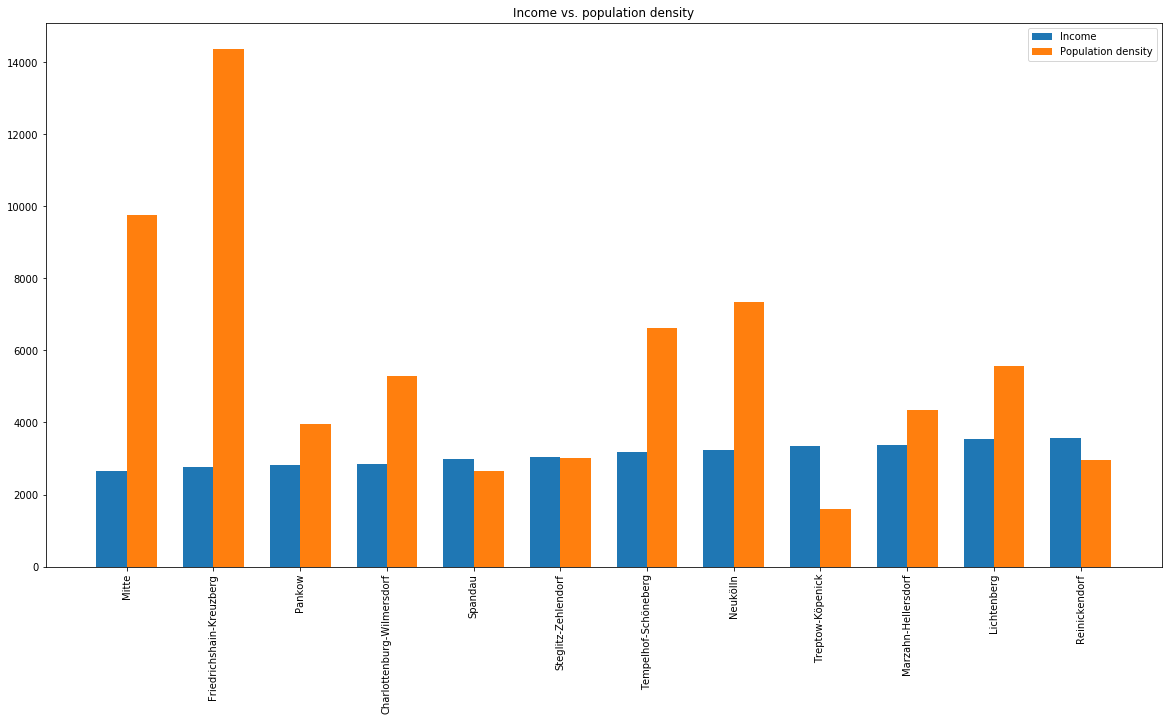

In [212]:
import matplotlib.pyplot as plt

labels = df['Borough']
income = df['income'].sort_values()
population = df['pop_dens']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars



fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, income, width, label='Income')
rects2 = ax.bar(x + width/2, population, width, label='Population density')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Income vs. population density')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

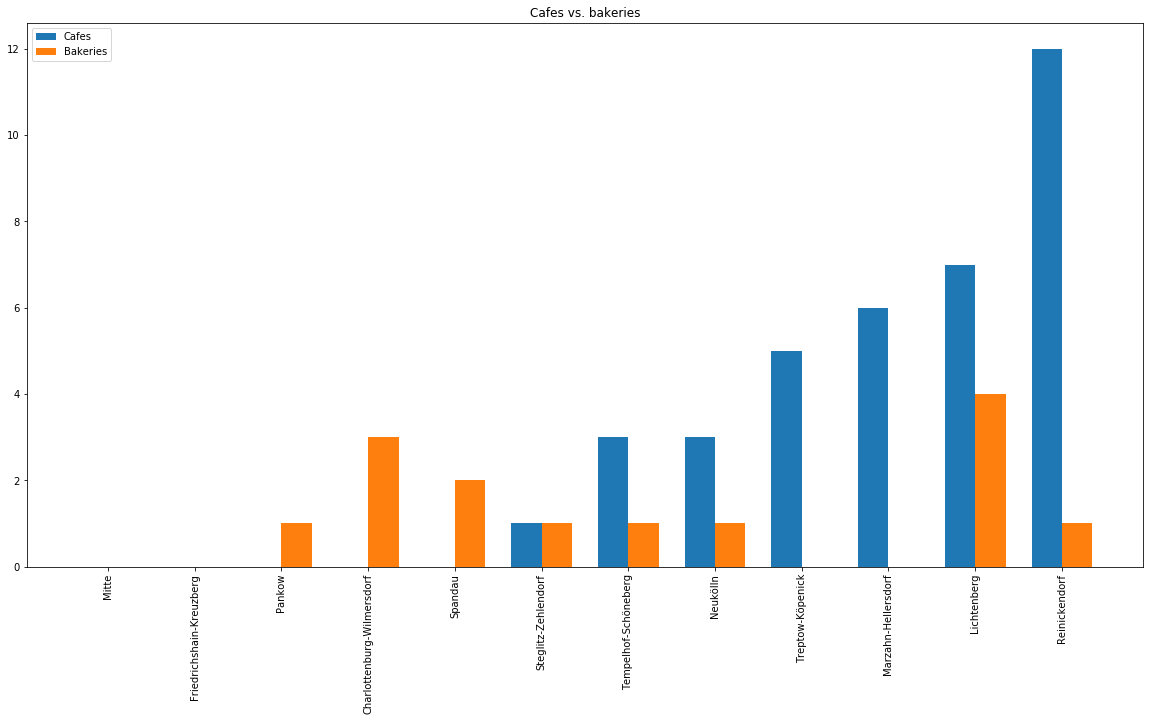

In [213]:
labels = df['Borough']
cafes_plot = df['Number of cafes'].sort_values()
bakeries_plot = df['Number of bakeries']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, cafes_plot , width, label='Cafes')
rects2 = ax.bar(x + width/2, bakeries_plot, width, label='Bakeries')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Cafes vs. bakeries')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

## Cluster analysis

In [216]:
df_clusters = df.drop(['Borough','lat', 'long','pop_dens', 'unemployed'],axis = 1)
df_clusters['Number of cafes per 1000 people'] = df_clusters['Number of cafes']/(df_clusters['population']/1000)
df_clusters['Number of bakeries per 1000 people'] = df_clusters['Number of bakeries']/(df_clusters['population']/1000)
#df_clusters = df_clusters.drop(['Cluster Labels', 'Population', 'Number of restaurants', 'Number of beer restaurants'], axis = 1)
df_clusters = df_clusters.drop(['population', 'Number of cafes', 'Number of bakeries'], axis = 1)
df_clusters.head()

,income,Number of cafes per 1000 people,Number of bakeries per 1000 people
0,3224,0.021253,0.000000
1,3375,0.046957,0.000000
2,3358,0.002923,0.002923
3,3573,0.019228,0.011537
4,2761,0.015881,0.010587


And of course, it is crucial, to perform normalization:

In [217]:
from sklearn.preprocessing import StandardScaler
df_clusters = StandardScaler().fit_transform(df_clusters)
df_clusters

array([[ 0.36574317,  0.64713088, -0.93102057],
       [ 0.87048546,  2.47121316, -0.93102057],
       [ 0.81366017, -0.65360799, -0.37860537],
       [ 1.53233296,  0.50344878,  1.24952818],
       [-1.18191034,  0.26592595,  1.07004836],
       [ 1.46547968,  1.00600526, -0.10221852],
       [ 0.26546325, -0.86100917, -0.24600082],
       [-0.86769991, -0.86100917, -0.23490511],
       [-0.24596437, -0.86100917, -0.93102057],
       [-1.56297405, -0.86100917, -0.93102057],
       [-1.01811979,  0.06492981,  2.35731022],
       [-0.43649623, -0.86100917,  0.00892535]])

To identify the optimal number of clusters, the Elbow method is used:

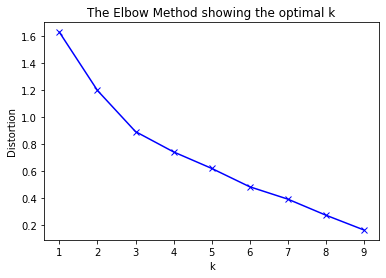

In [218]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_clusters)
    kmeanModel.fit(df_clusters)
    distortions.append(sum(np.min(cdist(df_clusters, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_clusters.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Great! On the graph, we can see that 3 clusters are enough:

In [219]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:24]

array([0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 1, 2])

Let's insert the Cluster labels into our master dataframe.

In [223]:
#df = df.drop('Cluster Labels', axis = 1)
df.insert(0, 'Cluster Labels', kmeans.labels_)
df.head()

,Cluster Labels,Borough,population,unemployed,income,pop_dens,lat,long,Number of cafes,Number of bakeries
0,0,Mitte,329372,78525,3224,9773,52.533216,13.359796,7,0
1,0,Friedrichshain-Kreuzberg,255551,47173,3375,14373,52.515306,13.461612,12,0
2,2,Pankow,342152,32405,3358,3958,52.597637,13.436374,1,1
3,0,Charlottenburg-Wilmersdorf,260040,31792,3573,5289,52.507856,13.263952,5,3
4,1,Spandau,188909,46611,2761,2655,52.534769,13.195629,3,2


Now, it's time to create maps representing our clusters. 

In [227]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'black', 'blue']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df['lat'], df['long'], df['Borough'], df['Cluster Labels'], df_clusters[:,1]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*5+15,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The second map is illustrating the clusters where the radius of the Circle marker is proportional to a Net income per person in each borough.

In [231]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'black', 'blue']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df['lat'], df['long'], df['Borough'], df['Cluster Labels'], df['income']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*0.0005-25,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

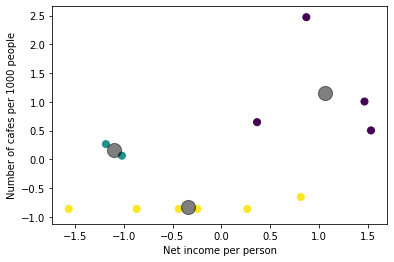

In [232]:
import matplotlib.pyplot as plt
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Net income per person')
plt.ylabel('Number of cafes per 1000 people')
plt.show()

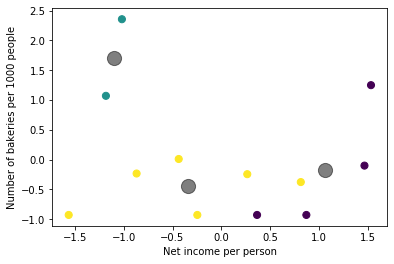

In [233]:
y_kmeans = kmeans.predict(df_clusters)
plt.scatter(df_clusters[:, 0], df_clusters[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);
plt.xlabel('Net income per person')
plt.ylabel('Number of bakeries per 1000 people')
plt.show()

In [234]:
df

,Cluster Labels,Borough,population,unemployed,income,pop_dens,lat,long,Number of cafes,Number of bakeries
0,0,Mitte,329372,78525,3224,9773,52.533216,13.359796,7,0
1,0,Friedrichshain-Kreuzberg,255551,47173,3375,14373,52.515306,13.461612,12,0
2,2,Pankow,342152,32405,3358,3958,52.597637,13.436374,1,1
3,0,Charlottenburg-Wilmersdorf,260040,31792,3573,5289,52.507856,13.263952,5,3
4,1,Spandau,188909,46611,2761,2655,52.534769,13.195629,3,2
5,0,Steglitz-Zehlendorf,228052,19531,3553,3012,52.429591,13.242024,6,1
6,2,Tempelhof-Schöneberg,275919,47451,3194,6625,52.440442,13.388289,0,1
7,2,Neukölln,271521,71203,2855,7338,52.445432,13.443460,0,1
8,2,Treptow-Köpenick,205326,26189,3041,1610,52.417988,13.626403,0,0
9,2,Marzahn-Hellersdorf,214913,43276,2647,4350,52.522464,13.585384,0,0


## Conclusion

Foursquare doesn't represent the full picture in Germany, since many venues are not on the list. 
Boroughs have too complex geometry, thus defining the closest venues within the certain radius brings additional error to our analysis.
